In [ ]:
import random
import varseek as vk
import os
import sys
import anndata as ad
import subprocess
import numpy as np
import pandas as pd

from varseek.utils import build_random_genome_read_df, fasta_to_fastq, create_mutant_t2g, fasta_to_fastq, find_genes_with_aligned_reads_for_kb_extract, calculate_metrics, create_stratified_metric_bar_plot, create_venn_diagram, get_header_set_from_fastq, plot_histogram, synthetic_data_summary_plot, plot_basic_bar_plot_from_dict, draw_confusion_matrix, check_for_read_kmer_in_mcrs, make_bus_df

In [2]:
out_dir_notebook="/home/jrich/data/varseek_data_fresh/vk_sim_2024dec17_complex_testing" #!!! change for each run
number_of_mutations_to_sample = 350
# Paths
mutation_metadata_df = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov16/mutation_metadata_df_updated_vk_info_exploded_filtered.csv"
mutation_index = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov16/mutation_reference.idx"
mutation_t2g = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov16/t2g_filtered.txt"



read_length = 150
strand = None  # None for strand-agnostic (randomly-selected), "f" for forward, "r" for reverse, "both" for both - make sure this matches the reference genome (vk build command) - strand = True -> "f" or "r" here; strand = False -> None or "both" here - note that the strand is randomly selected per *transcript*, such that all drawn reads will come from the same strand no matter what
add_noise_sequencing_error=True
add_noise_base_quality=False
error_rate=0.0001  # only if add_noise_sequencing_error=True
error_distribution=(0.85, 0.1, 0.05)  # sub, del, ins  # only if add_noise_sequencing_error=True
max_errors=float("inf")  # only if add_noise_sequencing_error=True
seq_id_column="seq_ID"
mut_column="mutation"
threads = 32
check_reason_for_read_fn = False
seed=42

number_of_random_reads_cdna = 10000
number_of_random_reads_genome = 0

k = 59  # w=54 - even if I will use k=59 in my experiments, my synthetic data is designed so that w=(read_length-1), meaning that the mutation can be anywhere on the read from the first to the last nucleotide, and thus I cannot catch these edge mutations if k > (w+1) - if I want to run where k > w+1, then adjust w internal to vk sim accoringly
w = 54

sequences = "/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"
reference_genome_fasta = "/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
reference_out_dir = "/home/jrich/data/varseek_data_fresh/reference"

In [3]:
out_dir_vk_build = f"{out_dir_notebook}/vk_build"

synthetic_reads_fastQ = f"{out_dir_notebook}/synthetic_reads.fq"
specific_fastq_selection = f"{out_dir_notebook}/specific_fastq_collection"
os.makedirs(specific_fastq_selection, exist_ok=True)
random_reads_fastq_cdna = f"{specific_fastq_selection}/random_reads_cdna.fq"
random_reads_fastq_genome = f"{specific_fastq_selection}/random_reads_genome.fq"
read_df_out = f"{out_dir_notebook}/synthetic_reads.csv"
mutation_metadata_df_out = f"{out_dir_notebook}/mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv"

kb_count_out = f"{out_dir_notebook}/kb_count_out"
kb_count_out_mm = f"{out_dir_notebook}/kb_count_out_mm"

read_df = None
mutation_metadata_df_path = mutation_metadata_df
adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"

read_df_out_updated = read_df_out.replace(".csv", "_updated.csv")
unique_mcrs_df_out = f"{out_dir_notebook}/unique_mcrs_df.csv"

plot_output_folder = f"{out_dir_notebook}/plots"
os.makedirs(plot_output_folder, exist_ok=True)

read_df_did_not_exist = False

if seed:
    random.seed(seed)
    np.random.seed(seed)

In [4]:
# # run vk ref or notebook 1_1 (vk build, vk info with save_exploded_df=True, vk filter, kb ref)

# Simple synthetic reads - erase

In [5]:
# #!!! TEMP
# import varseek
# mutation_metadata_df_path = mutation_metadata_df
# mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)

# sim_data_df_path = "/home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp2/vk_build/sim_data_df.csv"
# sim_data_df = pd.read_csv(sim_data_df_path, usecols=["header", "mutant_sequence", "wt_sequence"])

# sim_data_df.rename(
#     columns={
#         "mutant_sequence": "mutant_sequence_read_parent",
#         "wt_sequence": "wt_sequence_read_parent",
#     },
#     inplace=True,
# )

# sim_data_df["mutant_sequence_read_parent_rc"] = sim_data_df["mutant_sequence_read_parent"].apply(varseek.varseek_build.reverse_complement)
# sim_data_df["mutant_sequence_read_parent_length"] = sim_data_df["mutant_sequence_read_parent"].str.len()

# sim_data_df["wt_sequence_read_parent_rc"] = sim_data_df["wt_sequence_read_parent"].apply(varseek.varseek_build.reverse_complement)
# sim_data_df["wt_sequence_read_parent_length"] = sim_data_df["wt_sequence_read_parent"].str.len()

# mutation_metadata_df = pd.merge(
#     mutation_metadata_df,
#     sim_data_df[
#         [
#             "header",
#             "mutant_sequence_read_parent",
#             "mutant_sequence_read_parent_rc",
#             "mutant_sequence_read_parent_length",
#             "wt_sequence_read_parent",
#             "wt_sequence_read_parent_rc",
#             "wt_sequence_read_parent_length",
#         ]
#     ],
#     on="header",
#     how="left",
#     suffixes=("", "_read_parent"),
# )

In [6]:
# import sys
# import importlib

# # Remove the module from sys.modules
# if 'varseek.sim' in sys.modules:
#     del sys.modules['varseek.sim']

# # Import the module and reload it
# import varseek.varseek_sim
# importlib.reload(varseek.varseek_sim)
# import varseek as vk

# # instead of using vk.sim() as before, I must explicitely use vk.varseek_sim.sim()

In [ ]:
# #!!! TEMP
# sample_type = "all"
# conditions = ['dlist-equal=none', 'mcrs_is_substring-isnottrue', 'pseudoaligned_to_human_reference_despite_not_truly_aligning-isnottrue']  # kmer_overlap_in_mcrs_reference-isnottrue


# if not os.path.exists(mutation_metadata_df_out) or not os.path.exists(read_df_out):
#     simulated_df_dict = vk.sim(
#         mutation_metadata_df = mutation_metadata_df,
#         fastq_output_path = synthetic_reads_fastQ,
#         sample_type=sample_type,
#         number_of_mutations_to_sample=number_of_mutations_to_sample,
#         strand=strand,
#         number_of_reads_per_sample="all",  # not used when number_of_reads_per_sample_m and number_of_reads_per_sample_w are provided
#         k=k,  # used in vk build with the respective index
#         w=w,  # used in vk build with the respective index
#         read_length=read_length,
#         seed=None,
#         add_noise=add_noise,
#         error_rate=error_rate,
#         error_distribution=error_distribution,
#         max_errors=max_errors,
#         with_replacement=False,
#         sequences=sequences,
#         mutation_metadata_df_path=mutation_metadata_df_path,
#         seq_id_column=seq_id_column,
#         mut_column=mut_column,
#         reference_out_dir=reference_out_dir,
#         out_dir_vk_build=out_dir_vk_build,
#         filters=conditions,
#         read_df_out=read_df_out,
#         mutation_metadata_df_out=mutation_metadata_df_out,
#     )

#     read_df, mutation_metadata_df = simulated_df_dict["read_df"], simulated_df_dict["mutation_metadata_df"]
# else:
#     read_df = pd.read_csv(read_df_out)
#     mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

# Complex synthetic reads - uncomment

In [ ]:
# total = 0
# for mutant_depth in m_list:
#     total += mutant_depth * len(w_list) * len(conditions) * number_of_mutations_to_sample
# for wt_depth in w_list:
#     total += wt_depth * len(m_list) * len(conditions) * number_of_mutations_to_sample
# total += number_of_random_reads_cdna + number_of_random_reads_genome
# total_lines = total * 4
# print(total_lines)

91969600


In [7]:
#!!! ERASE
# number_of_mutations_to_sample = 5
# m_list = [1, 2, 3]
# w_list = [0, 1, 2]
# conditions = ['mutation_type-equal=substitution', 'mutation_type-notequal=substitution']

m_list = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
conditions = ['mutation_type-equal=substitution', 'mutation_type-notequal=substitution', 'kmer_overlap_in_mcrs_reference-isfalse', 'kmer_overlap_in_mcrs_reference-istrue', 'is_near_splice_junction_10-isfalse', 'is_near_splice_junction_10-istrue']

random.shuffle(m_list)
random.shuffle(w_list)

if not os.path.exists(mutation_metadata_df_out) and not os.path.exists(read_df_out):
    read_df_did_not_exist = True
    for mutant_sequencing_depth in m_list:
        for wt_sequencing_depth in w_list:
            for condition in conditions:
                read_fq_path_specific = f"{specific_fastq_selection}/synthetic_reads_m{mutant_sequencing_depth}_w{wt_sequencing_depth}_{condition.replace('=', '_')}.fq"
                condition_added_list = [condition, 'included_in_synthetic_reads-isnottrue']
                
                simulated_df_dict = vk.sim(
                    mutation_metadata_df = mutation_metadata_df,
                    fastq_output_path = read_fq_path_specific,
                    fastq_parent_path = synthetic_reads_fastQ,
                    read_df_parent=read_df,
                    sample_type="all",
                    number_of_mutations_to_sample=number_of_mutations_to_sample,
                    strand=strand,
                    k=k,
                    w=w,
                    number_of_reads_per_sample=None,  # not used when number_of_reads_per_sample_m and number_of_reads_per_sample_w are provided
                    number_of_reads_per_sample_m=mutant_sequencing_depth,
                    number_of_reads_per_sample_w=wt_sequencing_depth,
                    read_length=read_length,
                    seed=None,  # no need to pass in since it's set globally
                    add_noise_sequencing_error=add_noise_sequencing_error,
                    add_noise_base_quality=add_noise_base_quality,
                    error_rate=error_rate,
                    error_distribution=error_distribution,
                    max_errors=max_errors,
                    with_replacement=False,  # set to True if wanting to have some reads that might be identical
                    filters=condition_added_list,
                    sequences=sequences,
                    mutation_metadata_df_path=mutation_metadata_df_path,
                    seq_id_column=seq_id_column,
                    mut_column=mut_column,
                    reference_out_dir=reference_out_dir,
                    out_dir_vk_build=out_dir_vk_build,
                    read_df_out=read_df_out,
                    mutation_metadata_df_out=mutation_metadata_df_out,
                )

                mutation_metadata_df, read_df = simulated_df_dict['mutation_metadata_df'], simulated_df_dict['read_df']

read_df = pd.read_csv(read_df_out)
mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

/tmp/ipykernel_318327/3467447099.py:56: DtypeWarning: Columns (11,12,13,26,27,31,68,70) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)


# Random genome - uncomment

In [ ]:
# # do vk sim with random genome

# TODO: incorporate build_random_genome_read_df as a part of vk sim
if read_df_did_not_exist:
    if number_of_random_reads_cdna > 0:
        read_df = build_random_genome_read_df(reference_fasta_file_path = sequences, mutation_metadata_df = mutation_metadata_df, read_df = read_df, read_df_out=read_df_out, fastq_output_path = random_reads_fastq_cdna, fastq_parent_path = synthetic_reads_fastQ, n = number_of_random_reads_cdna, read_length = read_length, input_type = "transcriptome", strand = strand, add_noise_sequencing_error=add_noise_sequencing_error, add_noise_base_quality=add_noise_base_quality, seed=None)  # no need to pass in since it's set globally
    if number_of_random_reads_genome > 0:
        read_df = build_random_genome_read_df(reference_fasta_file_path = reference_genome_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, read_df_out=read_df_out, fastq_output_path = random_reads_fastq_genome, fastq_parent_path = synthetic_reads_fastQ, n = number_of_random_reads_genome, read_length = read_length, input_type = "genome", strand = strand, add_noise_sequencing_error=add_noise_sequencing_error, add_noise_base_quality=add_noise_base_quality, seed=None)

In [15]:
# kb count
kb_count_command = ["kb", "count", "-t", str(threads), "--mm", "-k", str(k), "-i", mutation_index, "-g", mutation_t2g, "-x", "bulk", "--num", "--h5ad", "--parity", "single", "-o", kb_count_out_mm, synthetic_reads_fastQ]
if not os.path.exists(kb_count_out_mm) or len(os.listdir(kb_count_out_mm)) == 0:
    subprocess.run(kb_count_command, check=True)

kb_count_command.remove("--mm")
kb_count_command[kb_count_command.index(kb_count_out_mm)] = kb_count_out  # swap kb_count_out_mm for kb_count_out
if not os.path.exists(kb_count_out) or len(os.listdir(kb_count_out)) == 0:
    subprocess.run(kb_count_command, check=True)

In [ ]:
bus_df_path = f"{kb_count_out_mm}/bus_df.csv"
if not os.path.exists(bus_df_path):
    bus_df = make_bus_df(kallisto_out = kb_count_out_mm, fastq_file_list = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = False, union = False, assay = "bulk", bustools = "/home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")
else:
    bus_df = pd.read_csv(bus_df_path)
bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

/tmp/ipykernel_110122/828376098.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  bus_df = pd.read_csv(bus_df_path)


In [18]:
import json
check_assertions = False
!cat {kb_count_out}/run_info.json | grep -E '"n_targets"|"n_processed"|"n_pseudoaligned"|"n_unique"|"p_pseudoaligned"|"p_unique"'

with open(f"{kb_count_out}/run_info.json", 'r') as f:
    data = json.load(f)

total_reads = data.get("n_processed", None)
n_pseudoaligned = data.get("n_pseudoaligned", None)
n_unique = data.get("n_unique", None)
n_multimapped = n_pseudoaligned - n_unique

if check_assertions:
    assert total_reads == n_pseudoaligned, "Total reads and pseudoaligned reads do not match"
    assert total_reads == n_unique, "Total reads and unique reads do not match"

	"n_targets": 5256981,
	"n_processed": 9077708,
	"n_pseudoaligned": 4107686,
	"n_unique": 4106153,
	"p_pseudoaligned": 45.3,
	"p_unique": 45.2,


# Perspective of reads

TP: 4107686, FP: 0, FN: 586826, TN: 4383196
Accuracy: 0.9353552680919016, Sensitivity: 0.874997443823767, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │      4107686       │       586826       │
│ Actual Negative │         0          │      4383196       │
└─────────────────┴────────────────────┴────────────────────┘

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

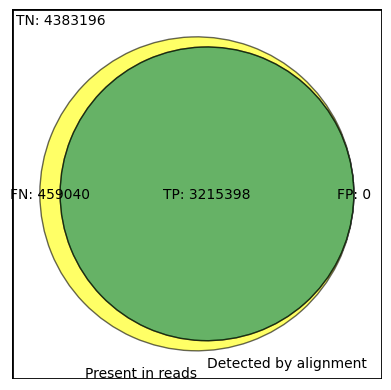

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:327: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not fo

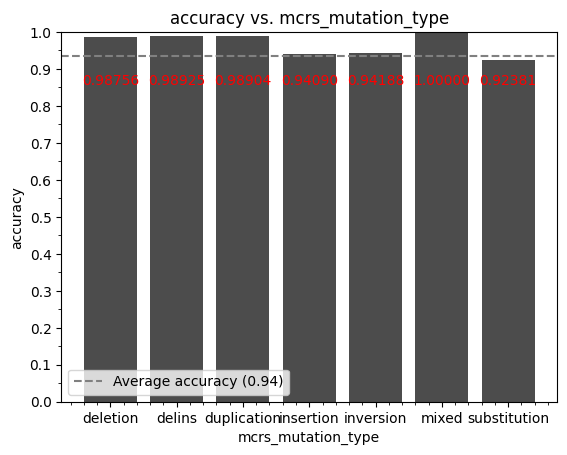

In [41]:
aligned_ids = set(bus_df['read_id'])
read_df['aligned_somewhere'] = read_df['read_id'].isin(aligned_ids)

read_df['TP_crude'] = (read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FP_crude'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FN_crude'] = (read_df['mutant_read'] & ~read_df['aligned_somewhere'])
read_df['TN_crude'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])

read_df['read_id_unique'] = read_df['read_id'] + "_" + read_df.index.astype(str)  # because, if I sample with replacement, some read_id's (and their matching read_header's) will be repeated

metric_dictionary_reads_crude = calculate_metrics(read_df, header_name = "read_id_unique", check_assertions = check_assertions, crude = True, out = f"{plot_output_folder}/reads_metrics_crude.txt")
draw_confusion_matrix(metric_dictionary_reads_crude)

true_set_crude = set(read_df.loc[read_df['mutant_read'], 'read_id_unique'])
positive_set_crude = set(read_df.loc[read_df['aligned_somewhere'], 'read_id_unique'])
# don't show mm here, because mm is counted as a TP for crude
create_venn_diagram(true_set_crude, positive_set_crude, TN = metric_dictionary_reads_crude['TN'], mm = None, out_path = f"{plot_output_folder}/venn_diagram_read_crude.png")

create_stratified_metric_bar_plot(read_df, 'mcrs_mutation_type', 'accuracy', overall_metric = metric_dictionary_reads_crude['accuracy'], log_x_axis = False, display_numbers = True, crude = True, out_path = f"{plot_output_folder}/accuracy_vs_mcrs_mutation_type_read_perspective_crude.png")

In [ ]:
from varseek.utils import safe_literal_eval

# Merge read_df with bus_df on 'read_id' and 'fastq_header' to bring in 'transcript_ids_list'
read_df = read_df.merge(bus_df[['read_id', 'transcript_ids_list', 'transcript_names_final']].drop_duplicates(), 
                          on='read_id', 
                          how='left').rename(columns={'transcript_names_final': 'mcrs_id_to_which_the_read_aligned'})

read_df["transcript_ids_list"] = read_df["transcript_ids_list"].apply(safe_literal_eval)

# Create 'multimapped' column as True if length of 'transcript_ids_list' > 1, else False
read_df['multimapped'] = read_df['transcript_ids_list'].apply(lambda x: len(x) > 1 if isinstance(x, list) else False)

read_df.drop(columns=['transcript_ids_list'], inplace=True)

read_df["mcrs_id_to_which_the_read_aligned"] = read_df["mcrs_id_to_which_the_read_aligned"].apply(safe_literal_eval)

# Convert lists to comma-separated strings, keeping NaN values as NaN
read_df['mcrs_id_to_which_the_read_aligned'] = read_df['mcrs_id_to_which_the_read_aligned'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else x
)

TP: 6438960, FP: 0, FN: 666654, TN: 4383196
Accuracy: 0.9419736247705376, Sensitivity: 0.9061792548821256, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │      6438960       │       666654       │
│ Actual Negative │         0          │      4383196       │
└─────────────────┴────────────────────┴────────────────────┘

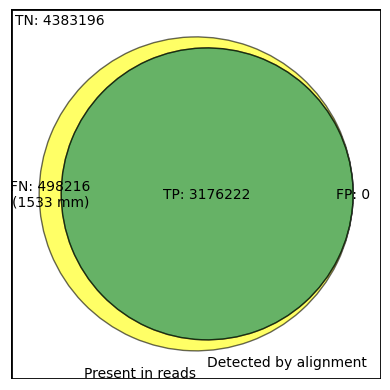

In [68]:
read_df['aligned_to_correct_mcrs'] = (read_df['mcrs_id'] == read_df['mcrs_id_to_which_the_read_aligned'])

# Check if 'mcrs_id' is a substring of any item in 'mcrs_id_to_which_the_read_aligned'
read_df['aligned_to_correct_mcrs_including_multimapped'] = read_df.apply(
    lambda row: row['mcrs_id'] in row['mcrs_id_to_which_the_read_aligned'] 
                if isinstance(row['mcrs_id_to_which_the_read_aligned'], str) else False,
    axis=1
)

read_df['TP'] = (read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FP'] = (~read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FN'] = (read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])
read_df['TN'] = (~read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])

metric_dictionary_reads = calculate_metrics(read_df, header_name = "read_id_unique", check_assertions = check_assertions, out = f"{plot_output_folder}/read_metrics.txt")
draw_confusion_matrix(metric_dictionary_reads)

true_set = set(read_df.loc[read_df['mutant_read'], 'read_id_unique'])
positive_set = set(read_df.loc[read_df['aligned_to_correct_mcrs'], 'read_id_unique'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reads['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read.png")

In [44]:
read_df['reason_for_fn'] = np.nan

if check_reason_for_read_fn:
    # Loop through each row in read_df where 'FN' is True
    for index, row in read_df.loc[read_df['FN']].iterrows():
        reason_for_fn_sublist = []

        # Get the mcrs_id from the current row in read_df
        mcrs_id = row['mcrs_id']
        
        # Find the corresponding mcrs_sequence_length in mutation_metadata_df
        matching_length = mutation_metadata_df.loc[
            mutation_metadata_df['mcrs_id'] == mcrs_id, 'mcrs_sequence_length'
        ]
        
        # Check if there's a match and if the length is less than 55
        if not matching_length.empty and matching_length.iloc[0] < (2*k-1):
            reason_for_fn_sublist.append("short_mcrs_id")

        if row['multimapped']:
            reason_for_fn_sublist.append("multimapped")
        
        dlist_status = mutation_metadata_df.loc[
            mutation_metadata_df['mcrs_id'] == mcrs_id, 'dlist'
        ]

        if not dlist_status.empty and dlist_status.iloc[0] != "none":
            reason_for_fn_sublist.append("dlisted")

        if reason_for_fn_sublist:
            read_df.at[index, 'reason_for_fn'] = reason_for_fn_sublist  # might be cast as a string if length == 1 (especially for first row), but this doesn't really matter for me

    num_nan_reasons = read_df.loc[read_df['FN'], 'reason_for_fn'].isna().sum()

    print(f"Number of FN reads with no reasons: {num_nan_reasons}")

    # mcrs_set = set(unique_mcrs_df.loc[unique_mcrs_df['FN'] == True, 'mcrs_header'])
    # filtered_read_df = read_df[(read_df['FN']) & (~read_df['reference_header'].isin(mcrs_set))]

# Perspective of reference

In [ ]:
columns_to_list = ["header","order","seq_ID","mutation","mutation_type","wt_sequence","nucleotide_positions","actual_mutation","mutation_cds","mutation_aa","GENOMIC_MUTATION_ID","chromosome","strand","mutation_genome","gene_name","mutation_id","start_mutation_position","end_mutation_position","nucleotide_positions_cdna","actual_mutation_cdna","start_mutation_position_cdna","end_mutation_position_cdna","header_genome","header_cdna","header_cds","nucleotide_positions_genome","actual_mutation_genome","start_mutation_position_genome","end_mutation_position_genome","distance_to_nearest_splice_junction","is_near_splice_junction_10","nearby_mutations","nearby_mutations_count","has_a_nearby_mutation"]
columns_to_or = ["included_in_synthetic_reads_mutant","included_in_synthetic_reads_wt","included_in_synthetic_reads", "any_noisy_reads", "any_noisy_reads_mutant", "any_noisy_reads_wt"]
columns_to_sum = ["list_of_read_starting_indices_mutant","list_of_read_starting_indices_wt","number_of_reads_wt","number_of_reads_mutant","noisy_read_indices_mutant","noisy_read_indices_wt"]
columns_to_all = []

# #!!!TEMP
# drop all columns in columns_to_list
columns_to_list.remove("order")
columns_to_list.remove("distance_to_nearest_splice_junction")
mutation_metadata_df.drop(columns=columns_to_list, inplace=True)
# #!!!TEMP

mutation_metadata_df_original_column_order = mutation_metadata_df.columns
columns_to_list = [col for col in columns_to_list if col in mutation_metadata_df_original_column_order]
columns_to_or = [col for col in columns_to_or if col in mutation_metadata_df_original_column_order]
columns_to_sum = [col for col in columns_to_sum if col in mutation_metadata_df_original_column_order]

for column in list(columns_to_list):
    mutation_metadata_df[column] = mutation_metadata_df[column].apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )

unique_mcrs_df = (
    mutation_metadata_df.sort_values('order').groupby('mcrs_header', as_index=False)
    .agg(
        {**{col: list for col in list(columns_to_list)},  # list these values
        **{col: sum for col in list(columns_to_sum)},  # Take the first value for these columns
        **{col: np.any for col in list(columns_to_or)},  # OR these values
        **{col: np.all for col in list(columns_to_all)},  # AND these values
        **{col: 'first' for col in mutation_metadata_df.columns if col not in columns_to_list + columns_to_or + columns_to_all + columns_to_sum + ['mcrs_header']}}  # Take the first value for other columns
    ).reset_index(drop=True)
)

unique_mcrs_df = unique_mcrs_df[mutation_metadata_df_original_column_order]

unique_mcrs_df['tumor_purity'] = unique_mcrs_df['number_of_reads_mutant'] / (unique_mcrs_df['number_of_reads_wt'] + unique_mcrs_df['number_of_reads_mutant'])

unique_mcrs_df['tumor_purity'] = np.where(
    np.isnan(unique_mcrs_df['tumor_purity']), 
    np.nan,  # Keep NaN as NaN
    unique_mcrs_df['tumor_purity']  # Keep the result for valid divisions
)

try:
    unique_mcrs_df['min_distance_to_splice_junction'] = unique_mcrs_df['distance_to_nearest_splice_junction'].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else np.nan
    )
except Exception as e:
    pass

In [ ]:
# TODO (very low priority): once I run more complex tests to verify that bus df and adata agree, then I can load in these values from bus df and remove the need to run kb count without mm

adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
adata = ad.read_h5ad(adata_path)

# Find the indices of non-zero values in adata.X
non_zero_indices = np.nonzero(adata.X)

# Get the non-zero values
non_zero_values = np.squeeze(np.asarray(adata.X[non_zero_indices])).astype(int)

# Get the corresponding gene names
mcrs_ids = adata.var.index[non_zero_indices[1]].to_numpy().flatten()

mcrs_ids = mcrs_ids.astype(str)

# Create a DataFrame
adata_df = pd.DataFrame({
    'mcrs_id': mcrs_ids,
    'number_of_reads_aligned_to_this_item': non_zero_values
})

unique_mcrs_df = unique_mcrs_df.merge(adata_df, on='mcrs_id', how='left')
unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

# # set to int - will need to do Int64 to work
# unique_mcrs_df['number_of_reads_mutant'] = unique_mcrs_df['number_of_reads_mutant'].astype(int)
# unique_mcrs_df['number_of_reads_wt'] = unique_mcrs_df['number_of_reads_wt'].astype(int)
# unique_mcrs_df['number_of_reads_aligned_to_this_item'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'].astype(int)

## Temporary detour: make sure bus_df and adata agree

In [ ]:
# # # uncomment this cell if making adata comparisons after the notebook has concluded
# # read_df = pd.read_csv(read_df_out_updated)
# # unique_mcrs_df = pd.read_csv(unique_mcrs_df_out)

# bus_df = pd.read_csv("/home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_500000mcrs_k59_nov16/kb_count_out_mm/bus_df.csv", usecols = ["transcript_names_final", "counted_in_count_matrix", "count"])

# adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
# adata = ad.read_h5ad(adata_path)

# # Find the indices of non-zero values in adata.X
# non_zero_indices = np.nonzero(adata.X)

# # Get the non-zero values
# non_zero_values = np.squeeze(np.asarray(adata.X[non_zero_indices])).astype(int)

# # Get the corresponding gene names
# mcrs_ids = adata.var.index[non_zero_indices[1]].to_numpy().flatten()

# mcrs_ids = mcrs_ids.astype(str)

# # Create a DataFrame
# adata_df = pd.DataFrame({
#     'mcrs_id': mcrs_ids,
#     'number_of_reads_aligned_to_this_item': non_zero_values
# })

In [ ]:
# from tqdm import tqdm
# tqdm.pandas()

bus_df_subset = bus_df[["transcript_names_final", "counted_in_count_matrix", "count"]]

if isinstance(bus_df_subset['transcript_names_final'][0], str):
    from varseek.utils import safe_literal_eval
    bus_df_subset["transcript_names_final"] = bus_df_subset["transcript_names_final"].apply(safe_literal_eval)

bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
    lambda x: x[0] if isinstance(x, list) and x else x
)

bus_df_subset['count_recorded_in_count_matrix'] = np.where(
    bus_df_subset['counted_in_count_matrix'],  # Condition
    bus_df_subset['count'],                   # Value if True
    0                                  # Value if False
)

bus_df_subset.drop(columns=['counted_in_count_matrix', 'count'], inplace=True)

# Group by the string representation
bus_df_subset_grouped = bus_df_subset.groupby('transcript_names_final', as_index=False).agg({
    'count_recorded_in_count_matrix': 'sum',
})

# # Set values in 'count' to 0 where 'counted_in_count_matrix' is False
# bus_df_subset_grouped.loc[bus_df_subset_grouped['counted_in_count_matrix'] == False, 'count'] = 0

bus_df_subset_grouped.rename(columns={"transcript_names_final": "mcrs_id", "count_recorded_in_count_matrix": "count_bus"}, inplace=True)


bus_df_subset_grouped = bus_df_subset_grouped.merge(adata_df, on='mcrs_id', how='left')
bus_df_subset_grouped = bus_df_subset_grouped.rename(columns={'number_of_reads_aligned_to_this_item': 'count_adata'})


bus_df_subset_grouped['count_adata'] = bus_df_subset_grouped['count_adata'].fillna(0)
bus_df_subset_grouped['count_bus'] = bus_df_subset_grouped['count_bus'].fillna(0)

mismatch_count = (bus_df_subset_grouped['count_bus'] != bus_df_subset_grouped['count_adata']).sum()
print(f"Number of mismatches between BUS file and adata: {mismatch_count}")

Number of mismatches between BUS file and adata: 0


/tmp/ipykernel_240960/682036471.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
/tmp/ipykernel_240960/682036471.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['count_recorded_in_count_matrix'] = np.where(
/tmp/ipykernel_240960/682036471.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

TP: 90, FP: 0, FN: 0, TN: 5299931
Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │         90         │         0          │
│ Actual Negative │         0          │      5299931       │
└─────────────────┴────────────────────┴────────────────────┘

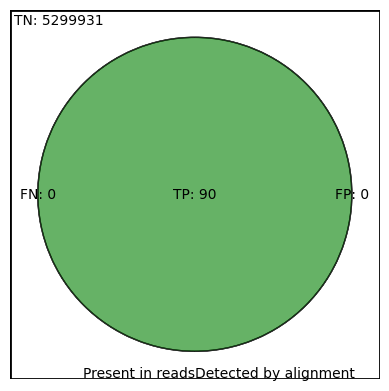

In [ ]:
unique_mcrs_df['TP_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FP_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FN_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['TN_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = check_assertions, crude = True, out = f"{plot_output_folder}/reference_metrics_crude.txt")
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference_crude.png")

In [ ]:
aligned_read_df_mutant = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['mutant_read'] == True)]
mcrs_counts_mutant = aligned_read_df_mutant.groupby('mcrs_id').size().reset_index(name='number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_mutant, on='mcrs_id', how='left')
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted




aligned_read_df_wt = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['wt_read'] == True)]
mcrs_counts_wt = aligned_read_df_wt.groupby('mcrs_id').size().reset_index(name='number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_wt, on='mcrs_id', how='left')
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_wt'] - unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

In [ ]:
# Step 1: Group by 'mcrs_header' and count 'aligned_to_correct_mcrs' (sum will count True as 1, False as 0)
aligned_counts = read_df.groupby('mcrs_header')['aligned_to_correct_mcrs'].sum().reset_index()

# Rename the column to something meaningful, like 'correct_alignment_count'
aligned_counts.rename(columns={'aligned_to_correct_mcrs': 'number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'}, inplace=True)

# Step 2: Merge the counts with unique_mcrs_df on the 'mcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, aligned_counts, on='mcrs_header', how='left')

# Fill NaN values with 0 in case some mcrs_header values in unique_mcrs_df do not appear in read_df
unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'].fillna(0, inplace=True)

unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'] = unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'] > 0

In [ ]:
# Step 1: Group by 'mcrs_header_to_which_the_read_aligned' and collect 'read_header' into lists
reads_mapped = read_df.groupby('mcrs_id_to_which_the_read_aligned')['read_header'].apply(list).reset_index()

# Rename the column to 'reads_mapped_to_this_reference_item' for clarity
reads_mapped.rename(columns={'read_header': 'reads_mapped_to_this_reference_item'}, inplace=True)

# Step 2: Merge the list of read headers with unique_mcrs_df on the 'mcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, reads_mapped, left_on='mcrs_id', right_on='mcrs_id_to_which_the_read_aligned', how='left')
unique_mcrs_df.drop(columns='mcrs_id_to_which_the_read_aligned', inplace=True)

# Fill NaN values with empty lists in case there are no matching read headers for some mcrs_header values
unique_mcrs_df['reads_mapped_to_this_reference_item'] = unique_mcrs_df['reads_mapped_to_this_reference_item'].apply(lambda x: x if isinstance(x, list) else [])

unique_mcrs_df['contained_any_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)
unique_mcrs_df['contained_any_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)

In [ ]:
unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = check_assertions, out = f"{plot_output_folder}/reference_metrics.txt")
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference.png")

unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_did_not_align_correctly'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']
unique_mcrs_df['number_of_reads_aligned_to_this_mcrs_item_that_aligned_incorrectly'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']

plot_histogram(unique_mcrs_df.loc[~unique_mcrs_df['TN']], 'mutation_expression_prediction_error', log_scale = False, out_path = f"{plot_output_folder}/histogram_mutation_expression_prediction_error_linear_axis.png")
plot_histogram(unique_mcrs_df.loc[~unique_mcrs_df['TN']], 'mutation_expression_prediction_error', log_scale = True, out_path = f"{plot_output_folder}/histogram_mutation_expression_prediction_error_log_axis.png")

metric_dictionary_reference['mutation_expression_prediction_error_abs_mean'] = unique_mcrs_df.loc[~unique_mcrs_df['TN'], 'mutation_expression_prediction_error'].abs().mean()
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'expression_error', overall_metric = metric_dictionary_reference['mutation_expression_prediction_error_abs_mean'], log_x_axis = False, out_path = f"{plot_output_folder}/expression_error_vs_number_of_reads_mutant.png")
# create_stratified_metric_bar_plot(unique_mcrs_df, 'min_distance_to_splice_junction', 'accuracy', overall_metric = metric_dictionary_reference['accuracy'], log_x_axis = False, bins = [-1, 0, 1, 5, 10, 50, 100, float('inf')])
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'sensitivity', overall_metric = metric_dictionary_reference['sensitivity'], log_x_axis = False, out_path = f"{plot_output_folder}/accuracy_vs_number_of_reads_mutant.png")
#* add more here
#*** create similar plots for y in {sensitivity, specificity}, and x in {number_of_reads_wt, tumor_purity} and determine cutoffs for which varseek is reliable

In [ ]:
unexplainable_references = 0
for header in metric_dictionary_reference['FNs']:
    print(f"Header {header}")
    did_not_align_anywhere = (read_df[read_df['mcrs_header'] == header])['FN_crude'].all()
    print(f"All did not align anywhere for {header}: {did_not_align_anywhere}")
    did_not_align_to_correct_position = (read_df[read_df['mcrs_header'] == header])['FN'].all()
    print(f"All did not align to correct mcrs for {header}: {did_not_align_to_correct_position}")
    multimapped = (read_df[read_df['mcrs_header'] == header])['multimapped'].all()
    print(f"All multimapped for {header}: {multimapped}")
    if not did_not_align_anywhere and not did_not_align_to_correct_position and not multimapped:
        unexplainable_references += 1

if unexplainable_references > 0:
    print(f"Unexplainable references: {unexplainable_references}")
else:
    print("All explainable!")

In [ ]:
unique_mcrs_df.to_csv(unique_mcrs_df_out, index=False)
read_df.to_csv(read_df_out_updated, index=False)

In [ ]:
# read_df = pd.read_csv(read_df_out_updated)
# unique_mcrs_df = pd.read_csv(unique_mcrs_df_out)

In [ ]:
print(read_df.columns)
print(unique_mcrs_df.columns)
print(mutation_metadata_df.columns)

In [ ]:
# eg /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp/plots/read_metrics.txt or /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp/plots/reference_metrics.txt
# no_noise_read_metrics = ""
# substitution_noise_read_metrics = ""
# deletion_noise_read_metrics = ""
# insertion_noise_read_metrics = ""
# all_noise_read_metrics = ""
# metric = "accuracy"

# from varseek.utils import retrieve_value_from_metric_file

# accuracy_dict = {}
# accuracy_dict['No Noise'] = retrieve_value_from_metric_file(metric, no_noise_read_metrics)
# accuracy_dict['Substitution Noise'] = retrieve_value_from_metric_file(metric, substitution_noise_read_metrics)
# accuracy_dict['Deletion Noise'] = retrieve_value_from_metric_file(metric, deletion_noise_read_metrics)
# accuracy_dict['Insertion Noise'] = retrieve_value_from_metric_file(metric, insertion_noise_read_metrics)
# accuracy_dict['All Noise'] = retrieve_value_from_metric_file(metric, all_noise_read_metrics)

# from matplotlib import pyplot as plt

# plot_basic_bar_plot_from_dict(accuracy_dict, y_axis=metric)

## Validating with kb extract

In [ ]:
# kb_extract_out_all_slow = f"{out_dir_notebook}/kb_extract_out_all_slow"
# df_extract_combined = pd.DataFrame(columns=['read_id', 'mcrs_id_to_which_the_read_aligned_kb_extract'])

# if strand is None or strand == "both":
#     strand_kb_extract = "unstranded"
# elif strand == "f":
#     strand_kb_extract = "forward"
# elif strand == "r":
#     strand_kb_extract = "reverse"

# # # running with --extract_all will make all ~5.3M reference items as the targets, which is much longer than manually defining the list of mutations as my targets - but I would imagine the outcome is the same; also, extract_all will output all files at once rather than one at a time (not good if I want to check progress throughout or break up for multithreading, but it can avoid the issue where mcrs_string_with_aligned_reads is too many characters)
# # kb_extract_command = f"kb extract --strand {strand_kb_extract} --verbose -k {k} -t {threads} --extract_all -o {kb_extract_out_all_slow} -i {mutation_index} -g {mutation_t2g} {synthetic_reads_fastQ}"
# adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
# mapped_mutations_string = find_genes_with_aligned_reads_for_kb_extract(adata_path)
# mcrs_set_with_aligned_reads = set(mapped_mutations_string.split())
# mcrs_string_with_aligned_reads = ' '.join(f"'{x}'" for x in mcrs_set_with_aligned_reads)
# kb_extract_command = f"kb extract --verbose -k {k} --mm -t {threads} --targets {mcrs_string_with_aligned_reads} -o {kb_extract_out_all_slow} -i {mutation_index} -g {mutation_t2g} {synthetic_reads_fastQ}"

# print(kb_extract_command)

run the command in tmux!

In [ ]:
# if 'bus_df' not in globals():
#     from varseek.utils import make_bus_df
#     bus_df = make_bus_df(kallisto_out = kb_count_out_mm, fastq_file_list = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = True, union = False, assay = "bulk", bustools = "/home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")
#     bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

# # add some code here to check where these map
# for subdir in os.listdir(kb_extract_out_all_slow):
#     subdir_path = os.path.join(kb_extract_out_all_slow, subdir)
#     if os.path.isdir(subdir_path):
#         fastq_file = os.path.join(subdir_path, '1.fastq.gz')
#         if os.path.exists(fastq_file):
#             # Run get_header_set_from_fastq for the fastq file
#             aligned_reads_kb_extract = get_header_set_from_fastq(fastq_file)
#             df_temp = pd.DataFrame(aligned_reads_kb_extract, columns=['read_id'])
#             df_temp['mcrs_id_to_which_the_read_aligned_kb_extract'] = subdir  # Add subdirectory info
#             df_extract_combined = pd.concat([df_extract_combined, df_temp], ignore_index=True)  # Concatenate the new DataFrame with df_extract_combined

# df_extract_combined = df_extract_combined.groupby('read_id')['mcrs_id_to_which_the_read_aligned_kb_extract'].apply(list).reset_index()

# df_extract_combined = df_extract_combined.merge(bus_df[["read_id", "gene_names_final"]], on='read_id', how='left')
# df_extract_combined.rename(columns={"gene_names_final": "mcrs_id_to_which_the_read_aligned_bus_df"}, inplace=True)
# mismatch_count_kb_extract = (df_extract_combined['mcrs_id_to_which_the_read_aligned_bus_df'] != df_extract_combined['mcrs_id_to_which_the_read_aligned_kb_extract']).sum()
# print(f"Number of mismatches between BUS file and kb extract: {mismatch_count_kb_extract}")